In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
% cd gdrive/MyDrive/nlp-unibuc/

/content/gdrive/MyDrive/nlp-unibuc


# Classification using BiLSTM

Firstly, we load the dataset and set the golden labels as we did in the previous notebook.

In [5]:
import pandas as pd

df = pd.read_csv("imdb_reviews.csv", index_col=0)
df.head()

,movie,title,text,score,user,date,helpfulness_votes,positive_helpfulness_votes
0,Couples Retreat,Worst movie I've seen in a while...,I watched this for free On Demand and still fe...,5.0,glyeakley,2010/09/25,47,30
1,Disaster Movie,The irony is very correct.,"Since the name of the movie is ""Disaster Movie...",NaN,mewte,2008/08/29,411,345
2,Seven Psychopaths,"Skinny, toothless, and blind","Hmm, it's quite risky with all these movies th...",6.0,mircea-lungu,2013/04/21,24,11
3,The Counselor,"A dark, bleak masterpiece about predators - 10/10",Don't believe the bad reviews here: If you lov...,10.0,rockenrohl,2013/10/26,139,86
4,Scouts Guide to the Zombie Apocalypse,Scouts vs. Zombies gotta like that!,Comedy and Horror mix well in this coming of a...,6.0,philipmorrison-73118,2016/01/24,3,2


In [6]:
df = df.drop(["movie", "title", "user", "date", "helpfulness_votes", "positive_helpfulness_votes"], axis=1)
df = df.dropna()
df = df.sample(n=10000)
print(len(df))
df.head()

10000


,text,score
30015,"""Lucky Number Slevin"" is a stylish revenge thr...",8.0
14909,You probably think this film is completely foc...,8.0
20188,"Reviewers Notes, humbly submitted: 1. One of t...",9.0
13265,"Every now and again, a film comes along that c...",6.0
22553,It's a nice film adaptation of a fairly nice t...,8.0


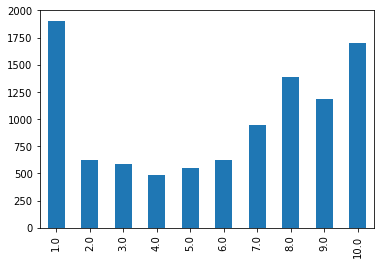

In [7]:
df["score"].value_counts().sort_index().plot(kind="bar")

In [8]:
def class_from_score(score):
    if score <= 3:
        return -1
    elif score >= 8:
        return 1
    else:
        return 0

df["class"] = [class_from_score(score) for score in df["score"]]
df.head()

,text,score,class
30015,"""Lucky Number Slevin"" is a stylish revenge thr...",8.0,1
14909,You probably think this film is completely foc...,8.0,1
20188,"Reviewers Notes, humbly submitted: 1. One of t...",9.0,1
13265,"Every now and again, a film comes along that c...",6.0,0
22553,It's a nice film adaptation of a fairly nice t...,8.0,1


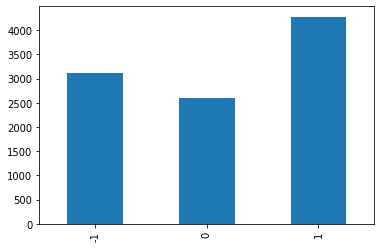

In [9]:
df["class"].value_counts().sort_index().plot(kind="bar")

We have now our texts labeled with positive, negative and neutral classes. We now proceed to split it into train (80%), dev (10%) and test (10%) subsets.

In [10]:
from sklearn.model_selection import train_test_split

df = df.drop(["score"], axis=1)
df_train, df_rest = train_test_split(df, test_size=0.2)
df_dev, df_test = train_test_split(df_rest, test_size=0.5)

df_train.reset_index(inplace=True, drop=True)
df_dev.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

print(len(df_train), len(df_dev), len(df_test))
df_train.head()

8000 1000 1000


,text,class
0,When the movie was made British actors were ch...,0
1,Nice performances by Chris Evans and Alice Eve...,1
2,The latest Will Smith effort is much different...,1
3,I guess one size doesn't fit all. As evidenced...,1
4,This is my first review on IMDb. I normally re...,0


## Data preparation for learning

Define the tokenizer using spacy.

In [11]:
! python -m spacy download en_core_web_md

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [12]:
import spacy

spacy_nlp = spacy.load("en_core_web_md", disable=["tagger", "parser", "ner", "textcat"])

def tokenize(text, spacy_nlp=spacy_nlp):
    urls_removed = text.replace("[URL]", "")
    lower_cased = urls_removed.lower()
    tokens = [token.text for token in spacy_nlp(lower_cased)]
    return tokens

print(tokenize(df_train.text[0]))

['when', 'the', 'movie', 'was', 'made', 'british', 'actors', 'were', 'chosen', 'to', 'play', 'the', 'roman', 'occupying', 'forces', ',', 'and', 'americans', 'to', 'play', 'the', 'oppressed', 'jews', '-', 'considering', 'their', 'roots', ',', 'that', 'would', 'of', 'course', 'appeal', 'to', 'americans', '.', 'but', 'things', 'have', 'changed', 'from', 'a', 'time', 'when', 'americans', 'would', 'see', 'themselves', 'as', '"', 'good', 'guys', '"', 'in', 'the', 'cold', 'war', '.', 'being', 'the', 'one', 'rome', '-', 'like', 'superpower', ',', 'it', "'s", 'the', 'united', 'states', "'", 'turn', 'to', 'impose', 'an', 'empire', "'s", 'glory', 'upon', 'the', 'world', 'whether', 'those', 'countries', 'with', 'unhealthy', 'climates', 'want', 'it', 'or', 'not', '.', 'when', 'i', 'watched', 'the', 'movie', 'the', 'other', 'day', 'parallels', 'with', 'the', 'current', 'situation', 'in', 'iraq', 'were', 'so', 'obvious', 'that', 'i', 'found', 'the', 'movie', 'quite', 'subversive', 'and', 'amusing', '

torchtext dataset from pandas dataframe

In [13]:
from torchtext import data

class DataFrameDataset(data.Dataset):

    def __init__(self, df, text_field, label_field, **kwargs):
        fields = [('text', text_field), ('label', label_field)]
        examples = []
        for i, row in df.iterrows():
            label = int(row["class"]) + 1  # classes are now 0,1,2
            text = row["text"]
            examples.append(data.Example.fromlist([text, label], fields))

        super().__init__(examples, fields, **kwargs)
    
    @staticmethod
    def sort_key(ex):
        return len(ex.text)

    @classmethod
    def splits(cls, text_field, label_field, train_df, dev_df=None, test_df=None, **kwargs):
        train_data, dev_data, test_data = (None, None, None)

        if train_df is not None:
            train_data = cls(train_df.copy(), text_field, label_field, **kwargs)
        if dev_df is not None:
            dev_data = cls(dev_df.copy(), text_field, label_field, **kwargs)
        if test_df is not None:
            test_data = cls(test_df.copy(), text_field, label_field, **kwargs)

        return tuple(d for d in (train_data, dev_data, test_data) if d is not None)

Defining the torchtext fields.

In [14]:
TEXT_FIELD = data.Field(
    sequential=True,
    tokenize=tokenize,
    batch_first=True,
    include_lengths=True
)

LABEL_FIELD = data.Field(
    sequential=False,
    use_vocab=False
)

Get train, dev, test datasets.

In [15]:
train_ds, dev_ds, test_ds = DataFrameDataset.splits(
  text_field=TEXT_FIELD, label_field=LABEL_FIELD, train_df=df_train, dev_df=df_dev, test_df=df_test
)

Build vocabulary on train set. Use 100-dimensional glove embeddings to initialize word embeddings.

In [16]:
import torch

MAX_VOCAB = 20000

TEXT_FIELD.build_vocab(
    train_ds,
    max_size=MAX_VOCAB,
    vectors="glove.6B.100d",
    unk_init=torch.Tensor.normal_,
)

Define data loaders.

In [17]:
BATCH_SIZE = 64

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

train_it, dev_it, test_it = data.BucketIterator.splits(
    (train_ds, dev_ds, test_ds),
    batch_size=BATCH_SIZE,
    sort_within_batch=True,
    device=DEVICE
)

Using device: cuda


## Model definition

We will define a model containing:
 * an embedding layer, using the glove pretrained embeddings for initialization
 * a BiLSTM layer
 * a dropout layer after the BiLSTM output
 * a dense layer for the classifier with relu activation
 * an output layer with softmax activation

In [18]:
import torch.nn as nn

class Model(nn.Module):
    def __init__(
        self, vocab_size, embedding_dim, hidden_dim, output_dim, lstm_num_layers,
        bidirectional, dropout_p, fc_size, pad_idx
    ):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=lstm_num_layers,
            bidirectional=bidirectional,
            dropout=dropout_p,
            batch_first=True,
        )
        self.dropout = nn.Dropout(dropout_p)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, fc_size),
            nn.ReLU(inplace=True),
            nn.Linear(fc_size, output_dim),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, sentences, lengths):
        embedded = self.dropout(self.embedding(sentences))
        # use packed sequences in order to ignore final padding when running through the lstm
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        # hidden has shape (2 * num_layers, batch_size, hidden_dim)
        # concat final forward and backward hidden layers and apply dropout
        hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
        return self.classifier(hidden)

In [19]:
VOCAB_SIZE = len(TEXT_FIELD.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 300
OUTPUT_DIM = 3
NUM_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
FC_SIZE = 1024
PAD_IDX = TEXT_FIELD.vocab.stoi[TEXT_FIELD.pad_token]

model = Model(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS, BIDIRECTIONAL, DROPOUT, FC_SIZE, PAD_IDX)

Now we are going to initialize the embedding leayer with the pretrained Glove vectors. TO do this we copy the vectors from the TEXT_FIELD.vocab into the weights of the embedding layer.

In [20]:
pretrained_emb = TEXT_FIELD.vocab.vectors
model.embedding.weight.data.copy_(pretrained_emb)

# initialize UNK and PAD token embeddings to 0
UNK_IDX = TEXT_FIELD.vocab.stoi[TEXT_FIELD.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.2631, -0.3419, -0.5652,  ...,  0.4034, -0.1465,  0.1182],
        [-0.4447,  0.1870, -0.4580,  ..., -0.1635, -0.4472, -0.2729],
        [ 0.0431,  0.4706,  1.0918,  ..., -0.1467, -0.3117,  0.2926]])


## Model training

We are now ready to train the model.
We will use Adam optimizer with the pytorch default learning rate.

In [21]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

We define the criterion as NLLLoss for cross entopy, we do this and not use the CrossEntropyLoss version since we already have the logits returned from the model.

In [22]:
criterion = nn.NLLLoss()

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [23]:
def count_matches(y_hat, y_true):
    matches = (y_hat == y_true).float()
    return matches.sum()

In [24]:
def train(epoch, model, loader, optimizer, criterion, print_freq=10):
    running_loss = 0
    running_acc = 0
    running_count = 0
    model.train()
    for i, batch in enumerate(loader):
        optimizer.zero_grad()
        sents, lengths = batch.text
        pred = model(sents, lengths)
        y_hat = pred.max(1)[1]  # class predictions
        y_true = batch.label
        running_acc += count_matches(y_hat, y_true).item()
        running_count += y_true.size(0)

        loss = criterion(pred, y_true)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

        if i % print_freq == 0:
             print(
                "Epoch: [{0}][{1}/{2}]\t"
                "Loss {3:.4f} ({4:.4f})\t"
                "Accuracy {5:.5f}".format(
                    epoch,
                    i + 1,
                    len(loader),
                    loss.item(),
                    running_loss / (i + 1),
                    running_acc / running_count,
                )
            )

    return running_loss / len(loader), running_acc / running_count


In [25]:
def evaluate(model, loader, criterion):
    running_loss = 0
    running_acc = 0
    running_count = 0
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(loader):
            sents, lengths = batch.text
            pred = model(sents, lengths)
            y_hat = pred.max(1)[1]  # class predictions
            y_true = batch.label
            running_acc += count_matches(y_hat, y_true).item()
            running_count += y_true.size(0)

            loss = criterion(pred, y_true)
            running_loss += loss.item()

    return running_loss / len(loader), running_acc / running_count

Training epochs. Save the best model based on validation loss.

In [27]:
import time

N_EPOCHS = 10

best_loss = float("inf")

train_losses = []
dev_losses = []
train_accs = []
dev_accs = []

for epoch in range(1, N_EPOCHS + 1):
    start_time = time.time()
    train_loss, train_acc = train(epoch, model, train_it, optimizer, criterion)
    dev_loss, dev_acc = evaluate(model, dev_it, criterion)
    end_time = time.time()
    epoch_time = end_time - start_time

    train_losses.append(train_loss)
    dev_losses.append(dev_loss)
    train_accs.append(train_acc)
    dev_accs.append(dev_acc)

    if dev_loss < best_loss:
        best_loss = dev_loss
        torch.save(model.state_dict(), "best_model.pth")

    print(f"Epoch {epoch} | Time: {epoch_time}")
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.4f}%')
    print(f'\t  Dev Loss: {dev_loss:.3f} |   Dev Acc: {dev_acc*100:.4f}%')

Epoch: [1][1/125]	Loss 1.0688 (1.0688)	Accuracy 0.43750
Epoch: [1][11/125]	Loss 1.1207 (1.0725)	Accuracy 0.43608
Epoch: [1][21/125]	Loss 1.0901 (1.0839)	Accuracy 0.40402
Epoch: [1][31/125]	Loss 1.0060 (1.0791)	Accuracy 0.41935
Epoch: [1][41/125]	Loss 1.0643 (1.0704)	Accuracy 0.42569
Epoch: [1][51/125]	Loss 1.0184 (1.0600)	Accuracy 0.44179
Epoch: [1][61/125]	Loss 1.0508 (1.0571)	Accuracy 0.44365
Epoch: [1][71/125]	Loss 1.3921 (1.0592)	Accuracy 0.44718
Epoch: [1][81/125]	Loss 1.0611 (1.0570)	Accuracy 0.45235
Epoch: [1][91/125]	Loss 1.0103 (1.0554)	Accuracy 0.45810
Epoch: [1][101/125]	Loss 1.0539 (1.0537)	Accuracy 0.45808
Epoch: [1][111/125]	Loss 1.0425 (1.0512)	Accuracy 0.45988
Epoch: [1][121/125]	Loss 1.1048 (1.0466)	Accuracy 0.46333
Epoch 1 | Time: 23.608086585998535
	Train Loss: 1.044 | Train Acc: 46.5875%
	  Dev Loss: 0.966 |   Dev Acc: 57.3000%
Epoch: [2][1/125]	Loss 0.8344 (0.8344)	Accuracy 0.71875
Epoch: [2][11/125]	Loss 1.0163 (0.9656)	Accuracy 0.55398
Epoch: [2][21/125]	Loss 0.8

Let's look at the performance of the best model on the test set.

In [78]:
model.load_state_dict(torch.load("best_model.pth"))
test_loss, test_acc = evaluate(model, test_it, criterion)

print(f"Test Loss: {test_loss:3f} | Test Acc: {test_acc * 100:4f}%")

Test Loss: 0.630804 | Test Acc: 72.500000%


The accuracy can be improved by tweaking some of the hyperparameters in the training and model. We will leave it like this for now, for the sake of demonstration.

Let's plot the train and validation statistics for loss and accuracy for each epoch.

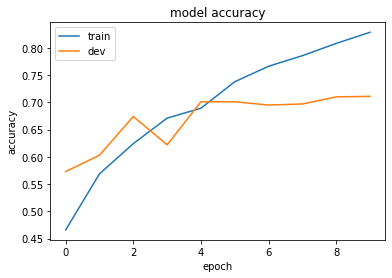

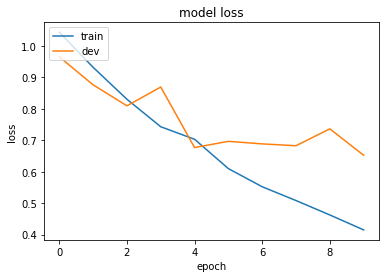

In [31]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(np.arange(N_EPOCHS), train_accs)
plt.plot(np.arange(N_EPOCHS), dev_accs)
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "dev"], loc="upper left")
plt.show()

plt.plot(np.arange(N_EPOCHS), train_losses)
plt.plot(np.arange(N_EPOCHS), dev_losses)
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "dev"], loc="upper left")
plt.show()

Let's make predictions for new texts.

In [114]:
def predict_class(model, sentence, tokenizer=tokenize, stoi=TEXT_FIELD.vocab.stoi, device=DEVICE):
    model.eval()
    tokens = tokenize(sentence)
    numericalized = [stoi[token] for token in tokens]
    length = [len(numericalized)]
    input = torch.LongTensor(numericalized).to(device)
    input = input.unsqueeze(0)  # size 1 batch
    length = torch.LongTensor(length)

    pred = model(input, length)
    y_hat = pred.max(1)[1]  # class predictions
    confidence = pred.max(1)[0]  # prediction confidence

    return y_hat.item(), torch.exp(confidence).item()

Evaluate test reviews one by one using predict and print accuracy.

In [119]:
from tqdm import tqdm

cnt = 0
for text, label in tqdm(zip(df_test.text, df_test["class"]), total=len(df_test.text)):
    y_hat, confidence = predict_class(model, text)
    if y_hat == label + 1:  # recall we reindexed the labels from -1/0/1 to 0/1/2
        cnt += 1
print()
print(cnt / len(df_test.text))

100%|██████████| 1000/1000 [00:47<00:00, 21.21it/s]


0.725


Some examples:

In [121]:
y_hat, confidence = predict_class(model, "This movie was amazing!")  # expected class: 2 (positive)
y_hat, confidence

(2, 0.9891038537025452)

In [123]:
y_hat, confidence = predict_class(model, "This movie was mediocre")  # expected class: 1 (neutral)
y_hat, confidence

(1, 0.6623865365982056)

In [124]:
y_hat, confidence = predict_class(model, "I have seen an awful movie...")  # expected class: 0 (negative)
y_hat, confidence

(0, 0.9356390833854675)